# Schrodinger-equation-DNN

In this project, I am going to display the power of Deep Neural Networks (Auto-encoder architecture) to solve the 1D time-independent Schrödinger equation.

If a particle is subject to a known potential $\boldsymbol{V}(x)$, we need to find the find it's wave function $\boldsymbol{\psi}(\boldsymbol{x})$ that satisfies the following relation:

$$ \frac{-\hbar^2}{2m} \frac{\partial ^2 }{\partial x^2}\psi (x) +\boldsymbol{V}(x)\psi(x) = \boldsymbol{E} \psi(x)$$


We are going to create syntetic pontentials of the type $\boldsymbol{V}(x) = \boldsymbol{\Sigma}_i \boldsymbol{\alpha}_i x^i$ and we will use their analytical solution to train an autoecoder that will essentially learn a non-linear map between the potential  $\boldsymbol{V}(x)$ of a particle and the associated wave function $\boldsymbol{\psi}(x)$ of a particle.

We will use the trained network to solve the Schödinger equation for the 1-Dimensional quantum harmonic oscillator and we will compare it using the analytical solution:

$$\psi_n(x) = \left(\frac{1}{\sqrt{2^n n!}}\right) \left(\frac{m\omega}{\pi\hbar}\right)^{1/4} e^{-\frac{m\omega x^2}{2\hbar}} H_n\left(\sqrt{\frac{m\omega}{\hbar}}x\right)
$$



### Imports

In [4]:
import numpy as np
from pylab import *  # for plot
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
import tensorflow as tf

from sklearn.model_selection import train_test_split



# Imports the function to generate the harmonic oscillator potential and the analytical wave function solution
from harmonic_oscillator import Harmonic_Oscillator

# Imports the autoencoder class we are going to use for the model
from autoencoder import Autoencoder, Training, BuildAutoencoder
from data_generation import *

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Generate potentials and wave functions for a power series potential in basis of harmonic oscilator

In [7]:
xmin = -8
xmax = 8
n_state = 0 # Keep in mind that the model will only predict the n state
N = 200
n_samples=200

# We generate the values of alpha
alpha_min = np.array([-150,-10,0.3,-0.1,0])/50
alpha_max = np.array([50,5,1.0,0.1,0.25])/50

k = alpha_min.shape[0]

r_alpha = np.random.random((int(n_samples*0.8), k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([-10,-1,0.1,0,0])
alpha_max2 = np.array([5,1,1.0,0,0])

r_alpha = np.random.random((int(n_samples*0.2), k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))
#print(alpha)

# TODO generate the data from the eigen state potential
data_gen = eigen_state_potential(alpha_min, alpha_max, N, xmin, xmax)
    
# TODO Generate the energies, wavefunctions and potentials

E, a, alpha = data_gen.generate_data(n_samples = n_samples, alpha=alpha, n_state = n_state, display = 100)
waves, x, φs = data_gen.final_wavefunction(xmin, xmax, N, a)
V, _ = data_gen.evaluate_potential(xmin, xmax, N, alpha)

idx=-1

NameError: name 'p' is not defined

561

## Print some if the simulated data

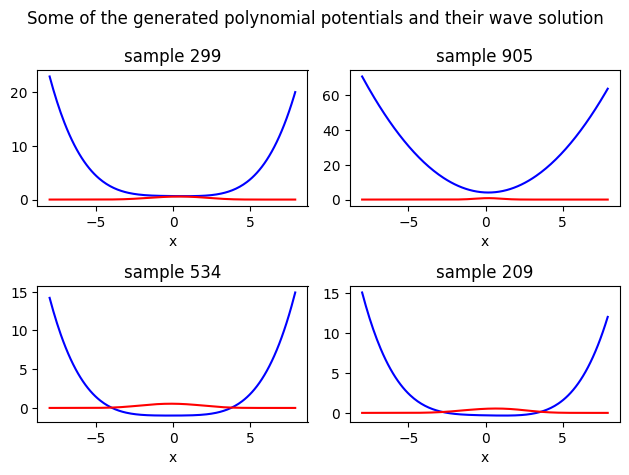

In [5]:
# Prints 4 random generated potentials


fig, axs = plt.subplots(2, 2)


rand_index = np.random.randint(low=0, high = n_samples)
axs[0, 0].plot(x, V[rand_index,:], '-b')
axs[0, 0].plot(x, waves[rand_index,:], '-r')
axs[0, 0].set_title(f'sample {rand_index}')


rand_index = np.random.randint(low=0, high = n_samples)
axs[0, 1].plot(x, V[rand_index,:], '-b')
axs[0, 1].plot(x, waves[rand_index,:], '-r')
axs[0, 1].set_title(f'sample {rand_index}')

rand_index = np.random.randint(low=0, high = n_samples)
axs[1, 0].plot(x, V[rand_index,:], '-b')
axs[1, 0].plot(x, waves[rand_index,:], '-r')
axs[1, 0].set_title(f'sample {rand_index}')

rand_index = np.random.randint(low=0, high = n_samples)
axs[1, 1].plot(x, V[rand_index,:], '-b')
axs[1, 1].plot(x, waves[rand_index,:], '-r')
axs[1, 1].set_title(f'sample {rand_index}')



fig.suptitle('Some of the generated polynomial potentials and their wave solution', fontsize=12)

for ax in axs.flat:
    ax.set(xlabel='x', ylabel='')
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.show()



## Generate Harmonic Oscillator solution

In [83]:

# class Harmonic_Oscillator:
#     '''
#     Class to generate potential and wavefunctions of an harmonic oscillator.
#     Attributes:
#     omega_min (float): Minimum value of omega
#     omega_max (float): Maximum value of omega
#     x0_min (float): Minimum value of x0
#     x0_max (float): Maximum value of x0
#     hbar (float): h bar
#     m (float): mass
#     N (int): number of points of the grid
#     omega (np.array): values of omega
#     x0 (np.array): values of x0
#     '''
#     def __init__(self, omega_min = 0.001, omega_max = 1, x0_min = -0.5, x0_max = 0.5,
#                      hbar = 1, m = 1, x_range = 0.8, N = 100):
#         self.omega_min = omega_min # omega ~ U(omega_min, omega_max)
#         self.omega_max = omega_max
#         self.x0_min = x0_min
#         self.x0_max = x0_max
#         self.hbar = hbar
#         self.m = m
#         self.find_xrange(x_range) # x in [-3 smax, 3smax]
#         self.N = N # Number of points of the grid 
#         self.omega=None
#         self.x0 = None

#     def find_xrange(self, x_range):
#         '''
#         Find range of x values x \in [-x_range * sigma_max, + x_range * sigma_max]
#         Args:
#         x_range (float)
#         '''
#         smax = np.sqrt(self.hbar/(self.m*self.omega_min)) # Find sigma_max
#         self.xmin = -x_range*smax
#         self.xmax = x_range*smax

#     def generate_omega(self, N):
#         '''
#         Generates new values of omega
#         Args:
#         N (int): number of samples
#         '''
#         if N==None:
#             N = 100
#         self.omega = np.random.uniform(self.omega_min, self.omega_max, N).reshape(-1,1)
#         self.x0 = np.random.uniform(self.x0_min, self.x0_max, N).reshape(-1,1)
    
#     def generate_data(self, N=None, n=None , new_omega=True):
#         '''
#         Generates N random data points from the energetic level n
#         Args:
#         N (int): number of samples
#         n (int): energetic level
#         new_omega (boolean): if True, new values of omega are generated
#         Returns:
#         φ_n (np.array): HO wavefunctions
#         x (np.array): grid
#         omega (np.array): omega values for each sample
#         x0 (np.array): values of x0 for each sample
#         potential (np.array): V(x)
#         '''
#         if new_omega or self.omega.any()==None or self.x0.any()==None:
#             self.generate_omega(N)

#         x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.N)
#         sigma_inv = np.sqrt(self.m*self.omega/self.hbar).reshape(-1,1)
#         ones = np.repeat(1, N)
#         x_mat = np.tensordot(x, ones, axes=0).T
#         all_x = (x_mat - self.x0)*sigma_inv # It is a matrix of dim (num_omega x num_x_points), 
#         # where each row has the values of x times sqrt(m*omega/hbar. In each row we change the value of omega
#         herm = eval_hermite(n, all_x) # H_n(x/sigma)
#         exp = np.exp(- all_x**2/2) # Exponential term

#         φ_n = exp*herm

#         h = (self.xmax - self.xmin)/self.N
#         C = 1./np.sqrt(np.sum(φ_n*φ_n*h, axis = 1)) #1/np.sqrt(2**n * math.factorial(int(n))) * np.sqrt(sigma_inv)# Normalization constant
#         C = C.reshape(-1,1)
#         φ_n = C*φ_n #exp*herm

#         potential = (x_mat-self.x0)**2 * 1/2*self.m*self.omega**2

#         return φ_n, x, self.omega, self.x0, potential

#     def get_energy(self, n, omega=np.array([None])):
#         '''
#         Get theoretical energy
#         Args:
#         n (int): energetic level
#         omega (np.array): values of omega
#         Returns:
#         E (np.array): energies
#         '''
#         if omega.any()==None:
#             omega = self.omega
#         E = self.hbar*omega*(n+1/2)
#         return E.flatten()

NameError: name 'np' is not defined

## Define and train the autoencoder with tensorflow


In [71]:
# class FC_Model(tf.keras.Model):
#     '''
#     Subclassed keras tf.keras.Model API. The input will be the potential V(x)
#     and the output will be the wave function φ_n(x).
#     Args:
#       input_size (int): Number of x points
#     Attributes:
#       input_size (int): Number of x points
#       fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
#       dropout1 (layer): Dropout layer with dropout parameter of 0.2
#       fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
#       dropout2 (layer): Dropout layer with dropout parameter of 0.2
#       fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
#       dropout3 (layer): Dropout layer with dropout parameter of 0.2
#       fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
#       dropout4 (layer): Dropout layer with dropout parameter of 0.2
#       out (layer): Output layer predicting φ_n(x) -> REGRESSION
#     '''
#     def __init__(self,
#                  name='fc_model', input_size=100,
#                  n1 = 256, n2= 256, n3=128, n4=128, drop=0.1, #n's are the neurons per layer
#                  **kwargs):
#         self.input_size = input_size
#         super(FC_Model, self).__init__(name=name, **kwargs)

#         # Fully connected layer.
#         self.fc1 = tf.keras.layers.Dense(n1,  activation='relu') 
#         # Apply Dropout (if is_training is False, dropout is not applied).
#         self.dropout1 = tf.keras.layers.Dropout(rate=drop)

#         # Fully connected layer.
#         self.fc2 = tf.keras.layers.Dense(n2,  activation='relu')
#         # Apply Dropout (if is_training is False, dropout is not applied).
#         self.dropout2 = tf.keras.layers.Dropout(rate=drop)

#         # Fully connected layer.
#         self.fc3 = tf.keras.layers.Dense(n3, activation='relu')
#         # Apply Dropout (if is_training is False, dropout is not applied).
#         self.dropout3 = tf.keras.layers.Dropout(rate=drop)

#         # Fully connected layer.
#         self.fc4 = tf.keras.layers.Dense(n4, activation='relu')
#         # Apply Dropout (if is_training is False, dropout is not applied).
#         self.dropout4 = tf.keras.layers.Dropout(rate=drop)

#         # Output layer (fully connected with input_size neurons and linear activation function )
#         self.out = tf.keras.layers.Dense(self.input_size, activation ='linear') 

#     @tf.function
#     def call(self, inputs, is_training=False):
#         '''
#         Forward pass of the fully connected model

#         Args:
#           inputs (tensor): X data to pass through the network (V(x))
#           is_training (bool): If training, True, otherwise, False
        
#         Returns:
#           out (tensor): Output tensor containing the values of φ_n(x)
#         '''
#         x = tf.reshape(inputs, tf.constant([-1, self.input_size]))
#         x = self.fc1(x) # x -> (g(1) o a(1))(x)
#         x = self.dropout1(x, training=is_training)
#         x = self.fc2(x)
#         x = self.dropout2(x, training=is_training)
#         x = self.fc3(x)
#         x = self.dropout3(x, training=is_training)
#         x = self.fc4(x)
#         x = self.dropout4(x, training=is_training)
#         out = self.out(x)
#         return out

In [72]:
# class Training():
#     '''
#     Performs the training of the autoencoder model using mean absolute error loss

#     Args:
#     net (Model): Model to train
#     learning_rate (float): Learning Rate for Adam optimizer
#     training_iters (int): Numer of training iterations
#     batch_size (int): Batch size
#     display_step (int): Number of iterations to wait to print the current performance of the model
#     early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
#     filepath (str): File path to store and recover the model weights
#     restore (bool): If true, it looks for existing weights to reestore them

#     Attributes: 
#     net (Model): Model to train
#     learning_rate (float): Learning Rate for Adam optimizer
#     training_iters (int): Numer of training iterations
#     batch_size (int): Batch size
#     display_step (int): Number of iterations to wait to print the current performance of the model
#     stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
#     early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
#     filepath (str): File path to store and recover the model weights
#     restore (bool): If true, it looks for existing weights to reestore them
#     loss (function): Loss function to optimize. In this case, mean square error
#     optimizer (tf.Optimizer): Adam optimizer for the learning steps
#     ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
#     manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
#     '''
#     def __init__(self, 
#                  net, #fc_model
#                  learning_rate, #alpha
#                  training_iters, #max number of epochs
#                  batch_size,
#                  display_step, 
#                  early_stopping=50, #if at a certain point, the validation loss is still growing for the next 50 epochs, you stop
#                  filepath=None, 
#                  restore =True):
#         self.net = net
#         self.learning_rate = learning_rate
#         self.training_iters = training_iters
#         self.batch_size = batch_size
#         self.display_step = display_step
#         self.stopping_step=0
#         self.loss = tf.keras.losses.MeanSquaredError()
#         self.early_stopping = early_stopping
#         self.optimizer = tf.keras.optimizers.legacy.Adam(self.learning_rate) # WARNING: we are using the legacy Adam optimizer because of speed issues
#         self.filepath = filepath
#         self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
#         self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)  
#         if restore:
#             self.ckpt.restore(self.manager.latest_checkpoint)
#             if self.manager.latest_checkpoint:
#                 print("Restored from {}".format(self.manager.latest_checkpoint))
#             else:
#                 print("Initializing from scratch.")

#     def loss_val(self, x_val, y_val):
#         '''
#         Computes the validation loss 
#         Args:
#         x_val(tensor): batch of validation sample
#         y_val (tensor): labels for validation
#         Returns:
#          val_loss(tensor): validation loss
#         '''
#         pred_val = self.net(x_val, False) #outside training mode, don't do dropout
#         val_loss = self.loss(pred_val, y_val) #prediction, target
#         return val_loss

#     def early_stop(self, epoch, val_loss, stop):
#         '''
#         Assesses if we have to stop training
#         Args:
#          epoch (int): current epoch
#          val_loss (tensor): current validation loss
#          stop (bool): early stop parameter
#         Returns:
#          stop(bool): True if the models stops training, false if it continues training
#          '''
#         #Store best validation loss
#         if epoch == 0:
#             self.best_loss = val_loss
#         else:
#             if val_loss < self.best_loss:
#                 self.stopping_step = 0
#                 self.best_loss = val_loss
#             else:
#                 #If the validation loss does not decrease, we increase the number of stopping steps
#                 self.stopping_step += 1
#         #If such number reaches the maximum, we stop training
#         if self.stopping_step == self.early_stopping:
#             stop = True
#             print('Early stopping was triggered ')
#         return stop

#     # Optimization process. 
#     @tf.function()
#     def run_optimization(self,x, y):
#         '''
#         Performs one step of the learning process. It calculates the loss function and
#         appies backpropagation algorithm to update the weights.

#         Args:
#         x (tensor): Samples of training data used to train the model
#         y (tensor): Labels for training data

#         Returns:
#         -
#         '''
#         # Wrap computation inside a GradientTape for automatic differentiation.
#         with tf.GradientTape() as g: #track how gradient evolves
#             # Forward pass.
#             pred = self.net(x)
#             # Compute loss.
#             loss = self.loss(pred, y)

#         # Variables to update, i.e. trainable variables.
#         trainable_variables = self.net.trainable_variables

#         # Compute gradients.
#         gradients = g.gradient(loss, trainable_variables) #chain rule

#         # Update W and b following gradients.
#         self.optimizer.apply_gradients(zip(gradients, trainable_variables))
#         return loss
      
#     #@tf.function
#     def fit(self, X_train,y_train, X_test,y_test, save=True):
#         '''
#         Main fit function 

#         Args:
#           X_train (numpy array): Processed training data
#           y_train (numpy array): Labels training data
#           X_test (numpy array): Processed test data (validation)
#           y_test (numpy array): Labels test data
#           save (bool): If true, we save the weights at the end of the training
#         Returns:
#           -
#           '''
#         # Create train and test datasets
#         # Use tf.data API to shuffle and batch data.
#         train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
#         train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1) #pick mini batches and shuffles


#         test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
#         test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size) 

#         loss_batch = []
#         val_loss_batch = []

#         stop = False
#         epoch = 0
#         # Run training for the given number of steps (and while not early stopping).
#         while epoch < self.training_iters and stop == False:
#             for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
#                 #Apply backpropagation algorithm
#                 loss = self.run_optimization(batch_x_train, batch_y_train)
#                 loss_batch.append(loss.numpy())

#                 for (test_x, test_y) in test_data:
#                     #Compute validation loss
#                     val_loss = self.loss_val(test_x, test_y)
#                     val_loss_batch.append(val_loss.numpy())

#                     stop = self.early_stop(epoch, val_loss, stop)
#                     epoch += 1

#             #Display the result
#             if epoch % self.display_step == 0:
#                 print('Epoch: ', epoch, "Validation loss: ", val_loss.numpy(), "Loss: ", loss.numpy())

#         #Save the weights
#         if save:
#             save_path = self.manager.save()
#             print("Saved checkpoint for step {}".format(save_path))    

# Generate harmonic oscilator data

In [6]:
V.shape

(1000, 200)

### Train the encoder using the generated data

In [7]:
# Split dataset in train and test 

V_train, V_test, waves_train, waves_test = train_test_split(np.arange(V.shape[0]), waves, test_size=0.2, random_state=69, shuffle=True)




# Parameters to train the neural network


N = 200
learning_rate = 0.0001
epochs = 100 
batch_size = 100
filepath ="models/"



model = BuildAutoencoder(input_size= N)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
hist = model.fit(V_train, waves_train, validation_split= 0.2, batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1, callbacks = [early_stopping])



Epoch 1/100


ValueError: in user code:

    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/juansmacbook/Desktop/Deep-Neural-Network-schrodinger-equation/.conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_1' (type Functional).
    
    Input 0 of layer "dense_12" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'model_1' (type Functional):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=True
      • mask=None


In [7]:


#model = Autoencoder(input_size=N)

# Train the model from scratch
# train = Training(model, 
#                  learning_rate, 
#                  training_iters, 
#                  batch_size,
#                  display_step, 
#                  early_stopping=200, 
#                  filepath=filepath, 
#                  restore =True)

# Restore the model from previously trained weights
# train = Training(fc_model,learning_rate, training_iters, batch_size, display_step, 
#                  filepath=filepath,early_stopping=100, restore=True)


# train.fit(V_train, wave_train, V_test, wave_test)




Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Restored from models/ckpt-5


2023-06-27 19:54:35.241857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-27 19:54:35.241892: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-27 19:54:35.707692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-27 19:54:35.855223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-27 19:54:35.896400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Early stopping was triggered 
Epoch:  4000 Validation loss:  0.0010603263623991748 Loss:  0.000170812554147396
Saved checkpoint for step models/ckpt-6


### Metrics on testing set

In [9]:
# MLP predictions
pred = model(V_test,False)
print("Test MSE for polynomial potential: %f" % train.loss(pred, wave_test))        
E = empirical_energy1D(wave_test, V_test)
E_emp = empirical_energy1D(pred, V_test)
print('MSE(E) for polynomial potential: ', np.mean((E - E_emp)**2))    


2023-06-27 19:55:10.439694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MSE for polynomial potential: 0.000548
MSE(E) for polynomial potential:  0.06846772273917996


### Comparing the solution of the autoencoder vs the target for a polynomial potential

Text(0.5, 1.0, 'Energies for polynomial potential')

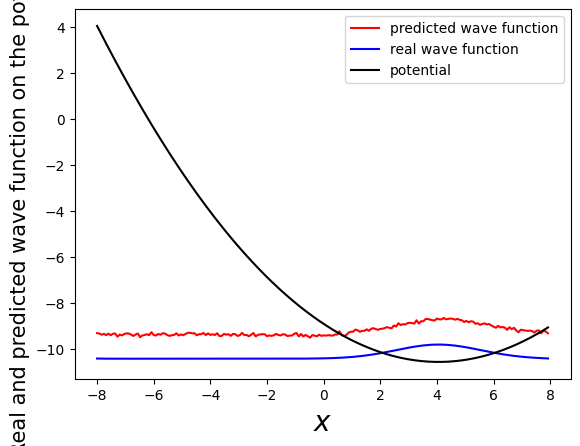

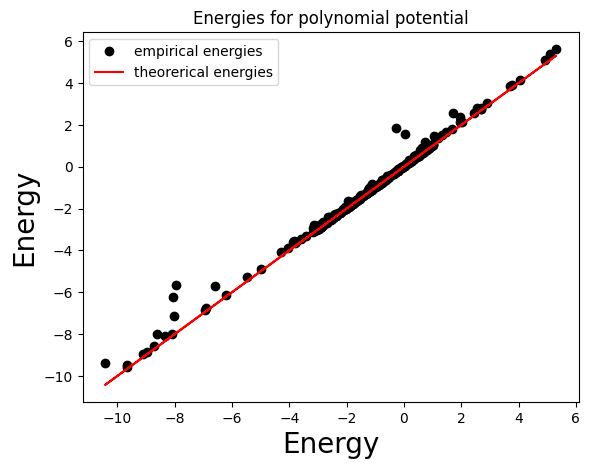

In [10]:
figure(5)
idx=30 #index on the dataset
plot(x,pred.numpy()[idx,:]+E_emp[idx],'-r')
plot(x,wave_test[idx,:]+E[idx],'-b') #real φ
plot(x,V_test[idx,:],'-k')         #Potential
legend(["predicted wave function","real wave function","potential"])
xlabel("$x$",size=20)
ylabel("Real and predicted wave function on the potential",size=15)


# plot Real and predicted mean energies
figure(6)
plot(E,E_emp,'ok') #empirical
plot(E,E,'-r') #theorerical
legend(["empirical energies","theorerical energies"])
xlabel("Energy",size=20)
ylabel("Energy",size=20)
title("Energies for polynomial potential")

# Generating harmonic oscilator data

[[ 3.89631288  3.82310808  3.75059751 ...  2.87779566  2.94135442
   3.0056074 ]
 [17.78240981 17.43856016 17.09806746 ... 14.8535056  15.17097715
  15.49180565]
 [15.95486853 15.65299126 15.35399719 ... 12.14821755 12.41433182
  12.6833293 ]
 ...
 [13.72547139 13.46607014 13.20914358 ... 10.39972163 10.62783361
  10.85842028]
 [ 1.30665345  1.2793129   1.25226143 ...  1.50135883  1.53096515
   1.56086054]
 [11.40318228 11.18743862 10.97375539 ...  8.68033885  8.87049986
   9.0627213 ]]
omega =%f
 [0.32935335]


<function matplotlib.pyplot.show(close=None, block=None)>

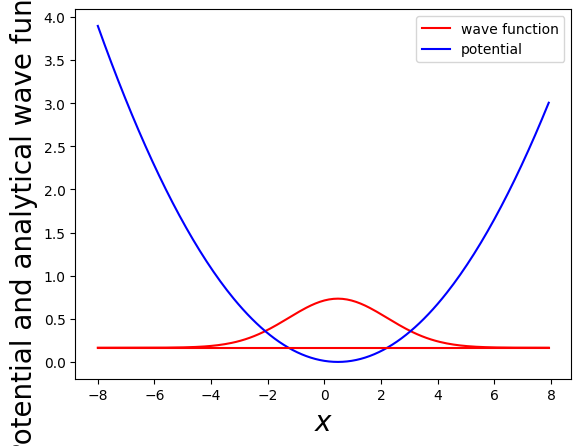

In [11]:
# TODO Generate H.O data
N = 200
n_state = 0


ho = Harmonic_Oscillator(N=N)
ho.xmax = 8
ho.xmin = -8

φ0_HO, x, omega, x0, potential_HO = ho.generate_data(N, n_state)
print(potential_HO)

#   plot
figure(3)
tmp_E=np.ones(N,float)
tmp_E=tmp_E*omega[0]*(1./2.+n_state)
print("omega =%f\n",omega[0])
plot(x,φ0_HO[0,:]+tmp_E[0],'-r')
plot(x,potential_HO[0,:],'-b')
plot(x,tmp_E,'-r')
legend(["wave function","potential"])
xlabel("$x$",size=20)
ylabel("Potential and analytical wave function",size=20)
show

## Testing the autoencoder with the quantum harmonic oscillator analytical solution

### Metrics 

Test MSE for HO: 0.001951
MSE(E) for HO:  0.0784497384334301


Text(0, 0.5, 'Real and predicted wave function on the harmonic potential')

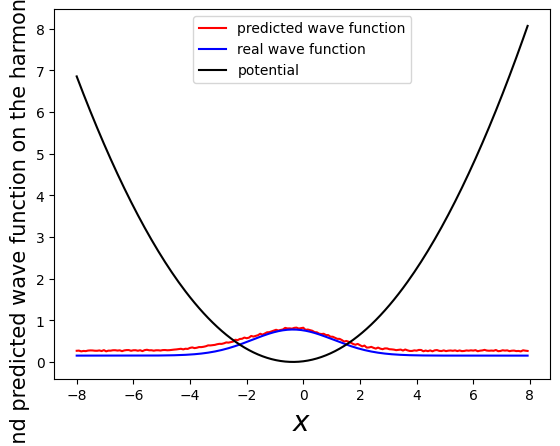

In [15]:
# Test with HO
# Predict wavefunctions 
pred_HO = model(potential_HO,False)
print("Test MSE for HO: %f" % train.loss(pred_HO, φ0_HO))
E = empirical_energy1D(φ0_HO, potential_HO)
E_emp = empirical_energy1D(pred_HO, potential_HO)
print('MSE(E) for HO: ', np.mean((E - E_emp)**2))




figure(7)
idx = 20 #1
plot(x,pred_HO.numpy()[idx,:]+E_emp[idx],'-r') #prediction φ
plot(x,φ0_HO[idx,:]+E[idx],'-b') #real φ
plot(x,potential_HO[idx,:],'-k') #Potential
legend(["predicted wave function","real wave function","potential"])
xlabel("$x$",size=20)
ylabel("Real and predicted wave function on the harmonic potential",size=15)

Text(0.5, 1.0, 'Energies for harmonic oscillator')

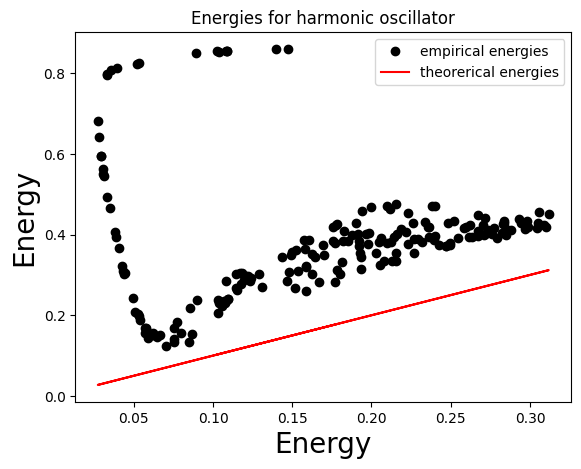

In [16]:
figure(8)
plot(E,E_emp,'ok')#  empirical
plot(E,E,'-r')#  theorerical
legend(["empirical energies","theorerical energies"])
xlabel("Energy",size=20)
ylabel("Energy",size=20)
title("Energies for harmonic oscillator")